# Análise de Cargas com Filtros FIR e IIR

Este trabalho foi desenvolvido pelos estudantes do curso de Engenharia de Computação da UFC Quixada, Guilherme Araújo Floriano, Eliton Pereira Melo e Ryan Guilherme Moraes Nascimento. 

Seu objetivo é aplicar os conceitos de projeto de filtros digitais (FIR e IIR) para analisar, identificar e caracterizar o consumo de cargas elétricas domésticas (NILM – Non-Intrusive Load Monitoring)

No trabalho anterior, foi desenvolvido filtros FIR para identificar eventos de ON/OFF em sinais obtidos pelo NILM e identifação do dispositivo pelo variação de potência durante esse evento. Agora, iremos utilizar a abordagem de filtros FIR para explorar melhor os Filtros IIR, adapatando a estrutura dos filtros e comparando os dois modelos. Dessa forma, vamos introduizir melhor o que são os Filtros IIR antes de partir para a remodelagem

## 1 - Introdução

A escolha entre um filtro FIR e um IIR é uma das decisões de projeto mais fundamentais em Processamento Digital de Sinais (PDS), envolvendo um compromisso clássico entre eficiência computacional e características de fase.

A principal característica que define um filtro IIR é a **realimentação (feedback)**. Diferente de um filtro FIR, onde a saída depende apenas de uma soma ponderada das amostras de entrada (passadas e presente), a saída de um filtro IIR depende tanto das **entradas** quanto das **saídas anteriores**.

* **FIR:** `Saída[n] = f(Entrada[n], Entrada[n-1], ...)`
* **IIR:** `Saída[n] = f(Entrada[n], Entrada[n-1], ...) + g(Saída[n-1], Saída[n-2], ...)`

Essa natureza recursiva faz com que a resposta a um único impulso, teoricamente, continue para sempre (de forma "infinita"), daí o nome.

### Vantagens dos Filtros IIR

A principal razão para se escolher um filtro IIR é a sua notável eficiência.

* **Eficiência Computacional e Baixa Ordem:** Esta é a maior vantagem. Um filtro IIR pode alcançar uma resposta em frequência muito "afiada" (ou seja, uma banda de transição estreita) com uma ordem drasticamente menor do que um filtro FIR com performance equivalente. No nosso trabalho, por exemplo, demonstramos que um filtro IIR de **ordem 5** pode ter um desempenho similar a um filtro FIR de **ordem 201**. Isso se traduz em:
    * Menos coeficientes para armazenar.
    * Menos operações de multiplicação e soma por amostra.
    * Maior velocidade de processamento, tornando-os ideais para aplicações em tempo real ou em hardware com recursos limitados.

### Desvantagens dos Filtros IIR

A eficiência dos filtros IIR vem com custos significativos, principalmente relacionados à fase do sinal.

* **Distorção de Fase (Principal Desvantagem):** Devido à sua natureza recursiva, filtros IIR possuem uma **fase não-linear**. Isso significa que diferentes componentes de frequência do sinal são atrasadas por quantidades de tempo diferentes ao passar pelo filtro. Na prática, isso pode **distorcer a forma de onda** do sinal no domínio do tempo, o que é problemático para muitas aplicações.
* **Solução para a Distorção de Fase:** Felizmente, para processamento de dados offline (onde temos todo o sinal disponível), podemos mitigar completamente este problema. Utilizando uma técnica de filtragem de passagem dupla com a função `filtfilt` da biblioteca SciPy, o sinal é filtrado uma vez na direção normal e outra vez na direção reversa. O resultado é um sinal filtrado com **distorção de fase zero**, combinando a eficiência do IIR com a fidelidade de fase do FIR.
* **Estabilidade:** Embora os métodos de projeto padrão (como Butterworth, Chebyshev) sempre gerem filtros estáveis, teoricamente, um filtro IIR pode se tornar instável se seus polos não forem projetados corretamente. Filtros FIR, por não terem realimentação, são sempre incondicionalmente estáveis.

### Tabela Comparativa: FIR vs. IIR

| Característica | Filtro FIR | Filtro IIR |
| :--- | :--- | :--- |
| **Eficiência (Ordem)** | Baixa (requer ordem alta para filtros "afiados"). | **Alta** (atinge a mesma performance com ordem muito menor). |
| **Fase** | **Linear** (não distorce a forma de onda no tempo). | Não-linear (causa distorção de fase). |
| **Estabilidade** | **Sempre estável**. | Pode ser instável (embora os métodos de projeto padrão garantam estabilidade). |
| **Estrutura** | Não-recursiva (sem feedback). | Recursiva (com feedback). |

Para o nosso projeto de NILM, onde a análise é feita offline e a eficiência computacional é valorizada, a conversão para filtros IIR, combinada com a técnica `filtfilt` para correção de fase, representa uma otimização de engenharia muito vantajosa.

## 2 - Análise das especificações e Redesenho do Filtro

Agora iremos converter os Filtros FIR já demosntrados, sendo eles o passa-alta detector de eventos e o passa-baixa caracterizador de potência para um design IIR. Mas antes de escolher o filtro IIR utilizado, vamos comparar os três para decidir. Dessa forma, dada as mesmas especificações já justificadas anteriormente, a ordem de cada filtro será obtido da seguinte forma:

In [132]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
import numpy as np
from nilmtk import DataSet

# Configuração para reduzir o tamanho das imagens
plt.rcParams['figure.dpi'] = 72  # Reduz DPI (padrão é 100)
plt.rcParams['savefig.dpi'] = 72
plt.rcParams['savefig.format'] = 'png'
plt.rcParams['savefig.bbox'] = 'tight'

# --- Carregamento do Dataset ---
print("Carregando o dataset HDF5...")
dataset = DataSet('../uk-dale.h5')

# Escolha a casa e o período para análise
building_num = 2

# dataset.set_window(start="2013-05-26", end="2013-05-27") # Tempo para casa 1
dataset.set_window(start="2013-04-25", end="2013-04-28") # Tempo para casa 2
# dataset.set_window(start="2013-02-27", end="2013-03-10") # Tempo para casa 3
#dataset.set_window(start="2013-03-09", end="2013-03-15") # Tempo para casa 4
#dataset.set_window(start="2014-06-29", end="2014-07-03") # Tempo para casa 5

elec = dataset.buildings[building_num].elec
mains_power = elec.mains().power_series_all_data().dropna()

print(f"Dados da Casa {building_num} carregados com sucesso.")
print(f"Período selecionado: de {mains_power.index[0]} a {mains_power.index[-1]}")

Carregando o dataset HDF5...
Dados da Casa 2 carregados com sucesso.
Período selecionado: de 2013-04-25 00:00:00.599999905+01:00 a 2013-04-27 23:59:59.799999952+01:00


### Analíse da Magnitude

Como podemos observar, mesmo no Butterworth, que possui a menor ordem, ainda assim ela é exponencialmente menor do que a utilizada no design do filtro FIR, sendo cerca de 25 vezes menor. Agora comparando as três estratégias temos o seguinte:

| Característica | Filtro de Butterworth | Filtro de Chebyshev (Tipo I) | Filtro Elíptico |
| :--- | :--- | :--- | :--- |
| **Ripple na Banda Passante** | Não (Maximamente plano) | Sim | Sim |
| **Ripple na Banda de Rejeição**| Não | Não | Sim |
| **Banda de Transição** | Larga | Mais estreita que Butterworth | A mais estreita de todos |
| **Fase** | Não linear | Não linear | Não linear |
| **Ordem do Filtro** | Mais alta | Intermediária | Mais baixa |
| **Uso Típico** | Quando uma resposta de fase suave é importante. | Aplicações que toleram ripple na banda passante. | Aplicações que exigem a transição mais íngreme. |

O que nos leva a discutir as caraterísticas do projeto. Ele possui uma certa criticidade quando a inclinação da banda de passagem, no entanto, ela não é o principal fator determinante no filtro passa-alta que já foi implementado, visto que basta ceifar a componente dc, o que todos fazem bem. Dessa forma, o fator principal é que não haja variações bruscas, os famosos riples.

Sendo assim, como o Filtro de Butterworth, por ser maximamente plano, não possui essas variações que podem interferir na leitura de transições, é o mais apto a ser esoclhido. Ademais, mesmo que ele possua uma ordem que seja o dobro do elíptico, ela não é elevada o suficiente para que sua escolha não seja válida, principalmente comparando com a necessária pelo FIR.

Os resultados podem ser vistos abaixo, bem como o código que o implementa.

Ordem necessária para Butterworth: 6
Ordem necessária para Chebyshev I: 4
Ordem necessária para Elíptico: 3
Ordem necessária para FIR: 185


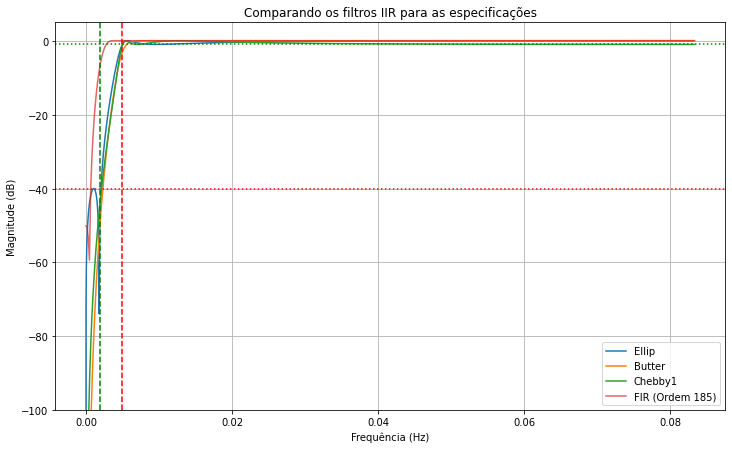

In [133]:
fs = 1 /6.0
fp, fr = 0.002, 0.005
gpass, gstop = 1, 40.0

# Normalizando
Wp = fp / (fs / 2)
Wr = fr / (fs / 2)

# Calculando a ordem necessária para cada tipo de filtro
ord_b, _ = signal.buttord(Wr, Wp, gpass, gstop)
ord_c, _ = signal.cheb1ord(Wr, Wp, gpass, gstop)
ord_e, _ = signal.ellipord(Wr, Wp, gpass, gstop)
ordem_fir = int(np.ceil(3.3/((fr-fp)/fs)) + 1)

print(f"Ordem necessária para Butterworth: {ord_b}")
print(f"Ordem necessária para Chebyshev I: {ord_c}")
print(f"Ordem necessária para Elíptico: {ord_e}")
print(f"Ordem necessária para FIR: {ordem_fir}")


b_ellip, a_ellip = signal.ellip(ord_e, gpass, gstop, Wr, 'high')
b_butter, a_butter = signal.butter(ord_b, Wr, 'high')
b_chebby, a_chebby = signal.cheby1(ord_c, gpass, Wr, 'high')
b_fir = signal.firwin(ordem_fir, cutoff=fp, fs=fs, window='hamming', pass_zero='highpass')

# --- Aplicação do Filtro ---
w_fir, h_fir = signal.freqz(b_fir, [1.0], fs=fs)
w_e, h_e = signal.freqz(b_ellip, a_ellip, fs=fs, worN=4096)
w_b, h_b = signal.freqz(b_butter, a_butter, fs=fs, worN=4096)
w_c, h_c = signal.freqz(b_chebby, a_chebby, fs=fs, worN=4096)

plt.figure(figsize=(12, 7))
plt.plot(w_e, 20 * np.log10(abs(h_e)), label='Ellip')
plt.plot(w_b, 20 * np.log10(abs(h_b)), label='Butter')
plt.plot(w_c, 20 * np.log10(abs(h_c)), label='Chebby1')
plt.plot(w_fir, 20 * np.log10(np.abs(h_fir) + 1e-9), label=f'FIR (Ordem {ordem_fir})', alpha=0.7)
plt.title(f'Comparando os filtros IIR para as especificações')
plt.xlabel('Frequência (Hz)'); plt.ylabel('Magnitude (dB)')
plt.axvline(fp, color='g', linestyle='--'); plt.axvline(fr, color='r', linestyle='--')
plt.axhline(-gpass, color='g', linestyle=':'); plt.axhline(-gstop, color='r', linestyle=':')
plt.grid(True, which='both'); plt.ylim(-100, 5)
plt.legend()
plt.show()


### Análise de Fase

Como esperado, a fase do filtro FIR é linear, não sofrendo variações abruptas com o tempo. No entanto, como observado nos filtros IIR, a fase não linear faz com que ela sofra uma variação diferente ao longo da frequência. Os resultados podem ser visto com mais clareza abaixo:

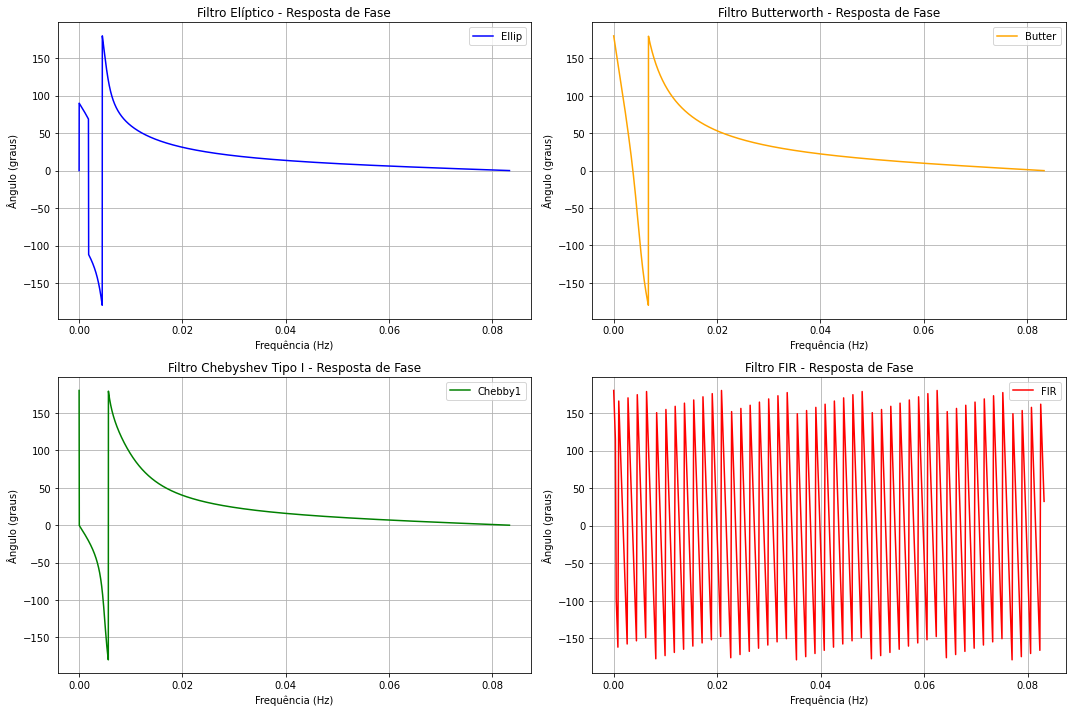

In [134]:
phase_fir =     np.angle(h_fir, deg=True)
phase_butter =  np.angle(h_b, deg=True)
phase_ellip =   np.angle(h_e, deg=True)
phase_cheby =   np.angle(h_c, deg=True)

# Criando uma figura com 4 subplots (2x2)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Gráfico 1: Filtro Elíptico
axes[0, 0].plot(w_e, phase_ellip, label='Ellip', color='blue')
axes[0, 0].set_title('Filtro Elíptico - Resposta de Fase')
axes[0, 0].set_xlabel('Frequência (Hz)')
axes[0, 0].set_ylabel('Ângulo (graus)')
axes[0, 0].grid(True)
axes[0, 0].legend()

# Gráfico 2: Filtro Butterworth
axes[0, 1].plot(w_b, phase_butter, label='Butter', color='orange')
axes[0, 1].set_title('Filtro Butterworth - Resposta de Fase')
axes[0, 1].set_xlabel('Frequência (Hz)')
axes[0, 1].set_ylabel('Ângulo (graus)')
axes[0, 1].grid(True)
axes[0, 1].legend()

# Gráfico 3: Filtro Chebyshev
axes[1, 0].plot(w_c, phase_cheby, label='Chebby1', color='green')
axes[1, 0].set_title('Filtro Chebyshev Tipo I - Resposta de Fase')
axes[1, 0].set_xlabel('Frequência (Hz)')
axes[1, 0].set_ylabel('Ângulo (graus)')
axes[1, 0].grid(True)
axes[1, 0].legend()

# Gráfico 4: Filtro FIR
axes[1, 1].plot(w_fir, phase_fir, label='FIR', color='red')
axes[1, 1].set_title('Filtro FIR - Resposta de Fase')
axes[1, 1].set_xlabel('Frequência (Hz)')
axes[1, 1].set_ylabel('Ângulo (graus)')
axes[1, 1].grid(True)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

### O Impacto da Fase Não-Linear

A fase não-linear dos filtros IIR é sua principal desvantagem e tem uma consequência direta no domínio do tempo: distorção da forma de onda.

Isso acontece porque cada componente de frequência do sinal é atrasada por uma quantidade de tempo diferente ao passar pelo filtro. Para aplicações como NILM, onde a forma e o momento exato de um transiente (o evento de ligar/desligar) são cruciais para a identificação, essa distorção pode:

* **"Borrar" o evento**: O início e o fim de um evento de comutação podem se tornar menos nítidos.
* **Alterar a assinatura**: A forma de onda característica de um aparelho ao ligar pode ser deformada, dificultando a classificação.
* **Introduzir artefatos**: Atrasos desiguais podem criar oscilações ou "ringing" ao redor de transições abruptas no sinal.
Em contrapartida, a fase linear do filtro FIR garante que todas as frequências sejam atrasadas igualmente, preservando a forma de onda do sinal e evitando distorção.

Em contrapartida, a fase linear do filtro FIR garante que todas as frequências sejam atrasadas igualmente, preservando a forma de onda do sinal e evitando distorção.

### Filtragem de Fase Zero com filtfilt

Felizmente, para análise de dados offline (onde todo o sinal está disponível de antemão), podemos contornar completamente o problema da fase não-linear dos filtros IIR usando uma técnica de filtragem de passagem dupla, implementada pela função signal.filtfilt da biblioteca SciPy.

O processo funciona da seguinte maneira:

1. Primeira Passagem (Forward): O sinal é filtrado da maneira convencional, do início ao fim. Isso introduz a distorção de fase característica do filtro IIR.
2. Segunda Passagem (Backward): O sinal resultante da primeira passagem é invertido no tempo e filtrado novamente pelo mesmo filtro.
3. Cancelamento da Fase: A distorção de fase introduzida na segunda passagem (reversa) cancela exatamente a distorção da primeira passagem (normal).

O resultado final é um sinal filtrado que possui a resposta de magnitude desejada do filtro IIR, mas com distorção de fase zero. Essencialmente, essa técnica nos permite obter o melhor dos dois mundos: a incrível eficiência computacional e a banda de transição íngreme de um filtro IIR com a fidelidade de fase de um filtro FIR.

Além disso, novamente o filtro de Butterworth é o mais indicado para os filtros em questão, visto que por mais que ele demore mais a atenuar a fase para zero como os outros filtros, que acaba sendo anulado pelo filtragem de fase zero, na parte principal do sistema que é nas frequências em torno de 0.005 ele apresenta a resposta mais próxima dos filtros FIR. 

## 3 - Aplicação do Filtro

Como toda a lógica dos filtros já foram abordados no trabalho anterior, esse trabalho focará mais na comparação, executando as estratégias nos três filtros IIR e nas suas características.

Agora aplicaremos os filtros IIR para fazer um comparativo com o equivalente no FIR. Como a abordagem de Chebyshev é bem semelhante a Eliptica, mas é um pouco pior pela ordem maior, iremos utilizar apenas a Eliptica e a de Butterworth, que pelas características já citadas é esperado apresentar características melhores.

In [135]:
def apply_and_compare_filters(b_fir, event_signal_iir, threshold, type:str):
    event_signal_fir = signal.filtfilt(b_fir, 1.0, mains_power)

    candidate_indices = np.where(np.abs(event_signal_fir) > threshold)[0]
    candidate_indices_iir = np.where(np.abs(event_signal_iir) > threshold)[0]

    # Agrupa eventos próximos para evitar detecções múltiplas para um único evento.
    # Se a distância entre dois pontos candidatos for menor que 5 amostras (30s), considera-se o mesmo evento.
    detected_event_indices = candidate_indices[np.where(np.diff(candidate_indices, prepend=0) > 5)[0]]
    detected_event_indices_iir = candidate_indices_iir[np.where(np.diff(candidate_indices_iir, prepend=0) > 5)[0]]

    detected_event_timestamps = mains_power.index[detected_event_indices]
    detected_event_timestamps_iir = mains_power.index[detected_event_indices_iir]

    print(f"Total de {len(detected_event_timestamps)} eventos detectados pelo Filtro FIR com limiar de {threshold}W.")
    print(f"Total de {len(detected_event_timestamps_iir)} eventos detectados pelo filtro IIR {type} com limiar de {threshold}W.")

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    axes[0, 0].plot(mains_power, label='Sinal Agregado (Mains)')
    axes[0, 0].plot(detected_event_timestamps, mains_power[detected_event_timestamps], 'o', color='red', markersize=8, label='Eventos Detectados (Filtro+Limiar)')
    axes[0, 0].set_title('Sinal Agregado e Eventos Detectados pelo Algoritmo FIR')
    axes[0, 0].set_ylabel('Potência (W)')
    axes[0, 0].grid()
    axes[0, 0].legend()

    axes[1, 0].plot(mains_power, label='Sinal Agregado (Mains)')
    axes[1, 0].plot(detected_event_timestamps_iir, mains_power[detected_event_timestamps_iir], 'o', color='red', markersize=8, label='Eventos Detectados (Filtro+Limiar)')
    axes[1, 0].set_title(f'Sinal Agregado e Eventos Detectados pelo Algoritmo IIR {type}')
    axes[1, 0].set_ylabel('Potência (W)')
    axes[1, 0].grid()
    axes[1, 0].legend()

    axes[0, 1].plot(mains_power.index, event_signal_fir, label='Saída do Filtro FIR (Eventos)', color='red')
    axes[0, 1].set_title('Saída do Filtro Detector de Eventos FIR')
    axes[0, 1].set_ylabel('Variação de Potência ($\Delta$W)')
    axes[0, 1].grid()
    axes[0, 1].legend()

    axes[1, 1].plot(mains_power.index, event_signal_iir, label=f'Saída do Filtro IIR {type} (Eventos)', color='red')
    axes[1, 1].set_title(f'Saída do Filtro Detector de Eventos IIR {type}')
    axes[1, 1].set_ylabel('Variação de Potência ($\Delta$W)')
    axes[1, 1].grid()
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

    return detected_event_timestamps_iir

Como esperado, o filtro Butterworth apresentou um desempenho muito bom, identificando até mesmo mais amostras que o filtro FIR, no entanto, algumas amostras ficaram defasadas mesmo com a estratégia do Filtragem de Fase zero com relação ao FIR. Essas características e uma análise com zoom para identificar se o filtro não pegou falsos negativos ou positivos serão abordados posteriormente.

Total de 211 eventos detectados pelo Filtro FIR com limiar de 500.0W.
Total de 212 eventos detectados pelo filtro IIR Butterworth com limiar de 500.0W.


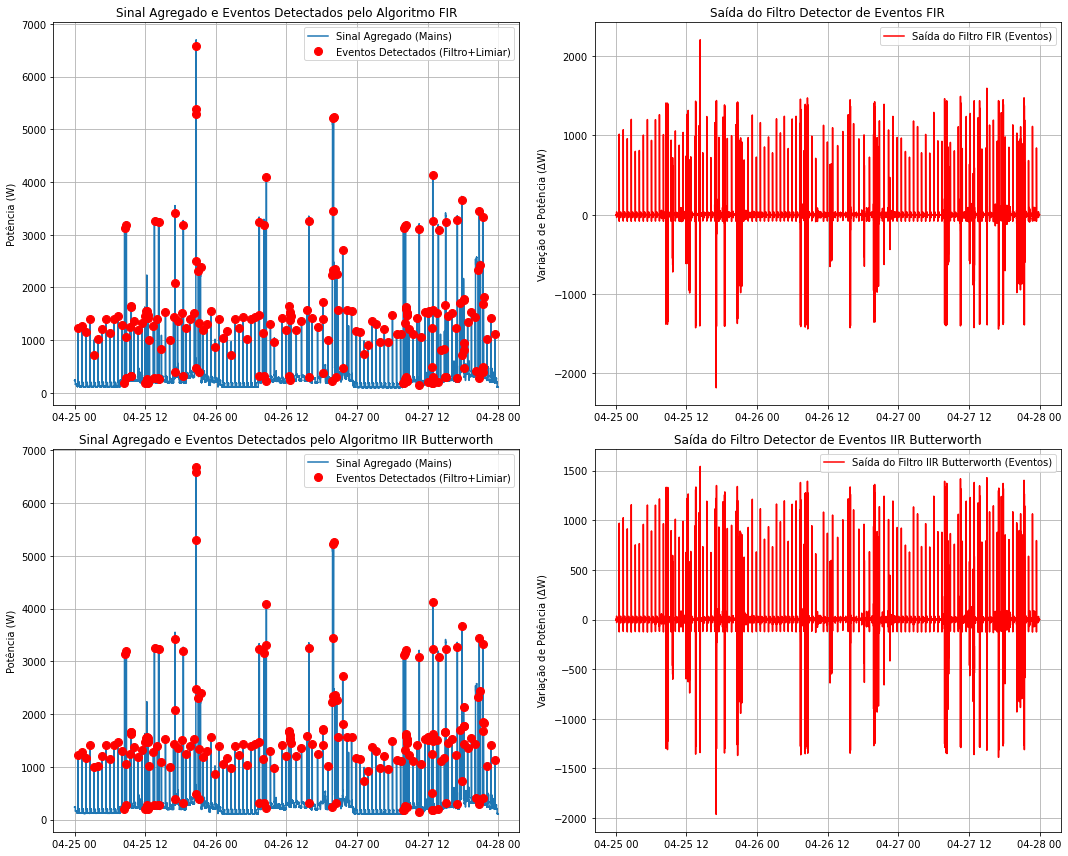

In [136]:
threshold = 500.0

event_signal_butter = signal.filtfilt(b_butter, a_butter, mains_power)
detected_event_timestamps_butter = apply_and_compare_filters(b_fir, event_signal_butter, threshold, type="Butterworth")

Agora sobre o Chebyshev, seu desempenho foi considerável considerando a baixa ordem, mas devido á demora de amortizar os lóbulos secundários, ele acaba por perder a identicação de algumas amostras. Sua única vantagem é ter a fase um pouco menos deslocada que o Butterwort, o que nesse contexto não é tão relevante, já que a diferença é na ordem de milisegundos, sendo totalmente aceitável por parte do Butterworth.

Total de 211 eventos detectados pelo Filtro FIR com limiar de 500.0W.
Total de 193 eventos detectados pelo filtro IIR Chebyshev com limiar de 500.0W.


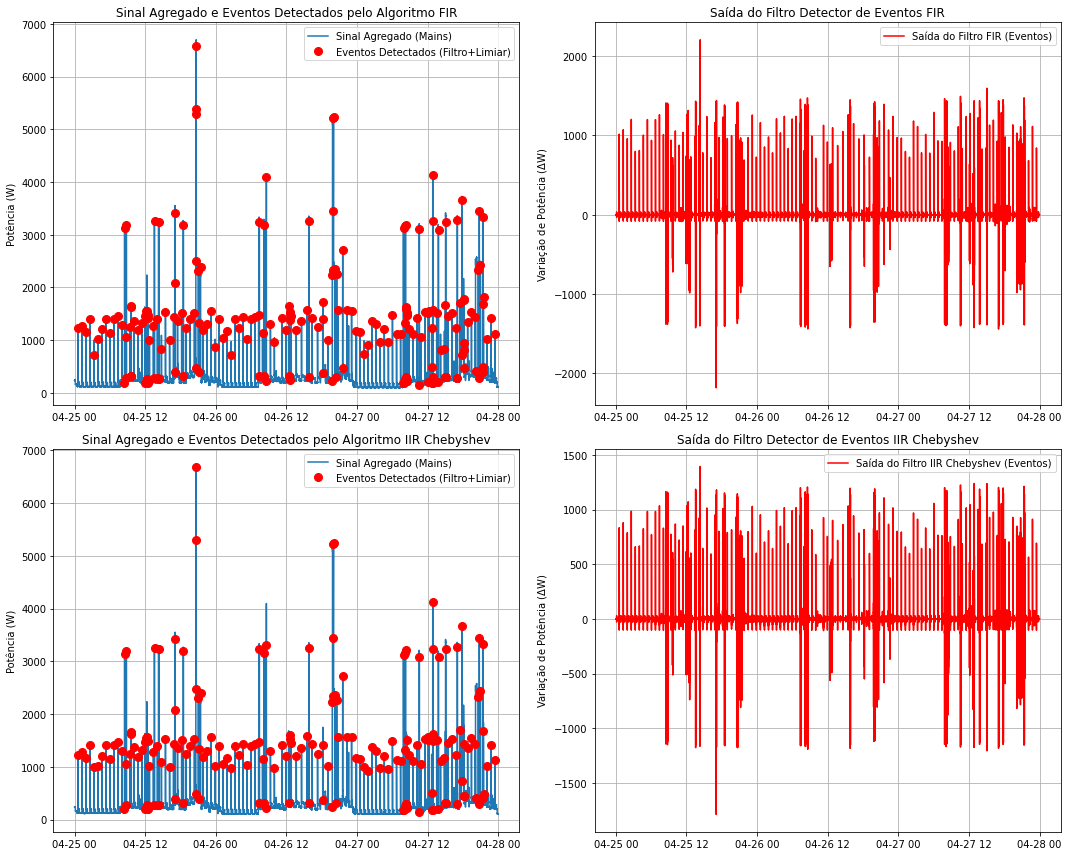

DatetimeIndex(['2013-04-25 00:34:17.400000095+01:00',
               '2013-04-25 01:15:32.099999905+01:00',
                  '2013-04-25 01:56:35.500000+01:00',
                         '2013-04-25 02:37:21+01:00',
               '2013-04-25 03:18:10.599999905+01:00',
               '2013-04-25 03:59:17.900000095+01:00',
                  '2013-04-25 04:40:19.500000+01:00',
               '2013-04-25 05:21:37.099999905+01:00',
                  '2013-04-25 06:03:12.500000+01:00',
               '2013-04-25 06:43:45.900000095+01:00',
               ...
               '2013-04-27 20:45:26.900000095+01:00',
               '2013-04-27 20:47:15.799999952+01:00',
               '2013-04-27 20:59:46.299999952+01:00',
               '2013-04-27 21:22:05.599999905+01:00',
               '2013-04-27 21:25:25.400000095+01:00',
               '2013-04-27 21:27:41.299999952+01:00',
               '2013-04-27 21:30:31.200000048+01:00',
                         '2013-04-27 22:07:56+01:00',
         

In [137]:
event_signal_chebby = signal.filtfilt(b_chebby, a_chebby, mains_power)
apply_and_compare_filters(b_fir, event_signal_chebby, threshold, type="Chebyshev")
#

Agora no eliptico, o resultado foi bem mais satisfatório que no Chebyshev, tendo uma defasem parecida. Além disso, algumas amostras ficaram de fora do dector, provavelmente pelo mesmo motivo da fase, mas foram bem menos do que no resultado anterior utilizando um grau menor, dado a grande eficiência que esse filtro traz, mas como a diferença das ordens não foi tão significativa, o resultado do Butterworth parece melhor.

Total de 211 eventos detectados pelo Filtro FIR com limiar de 500.0W.
Total de 206 eventos detectados pelo filtro IIR Elíptico com limiar de 500.0W.


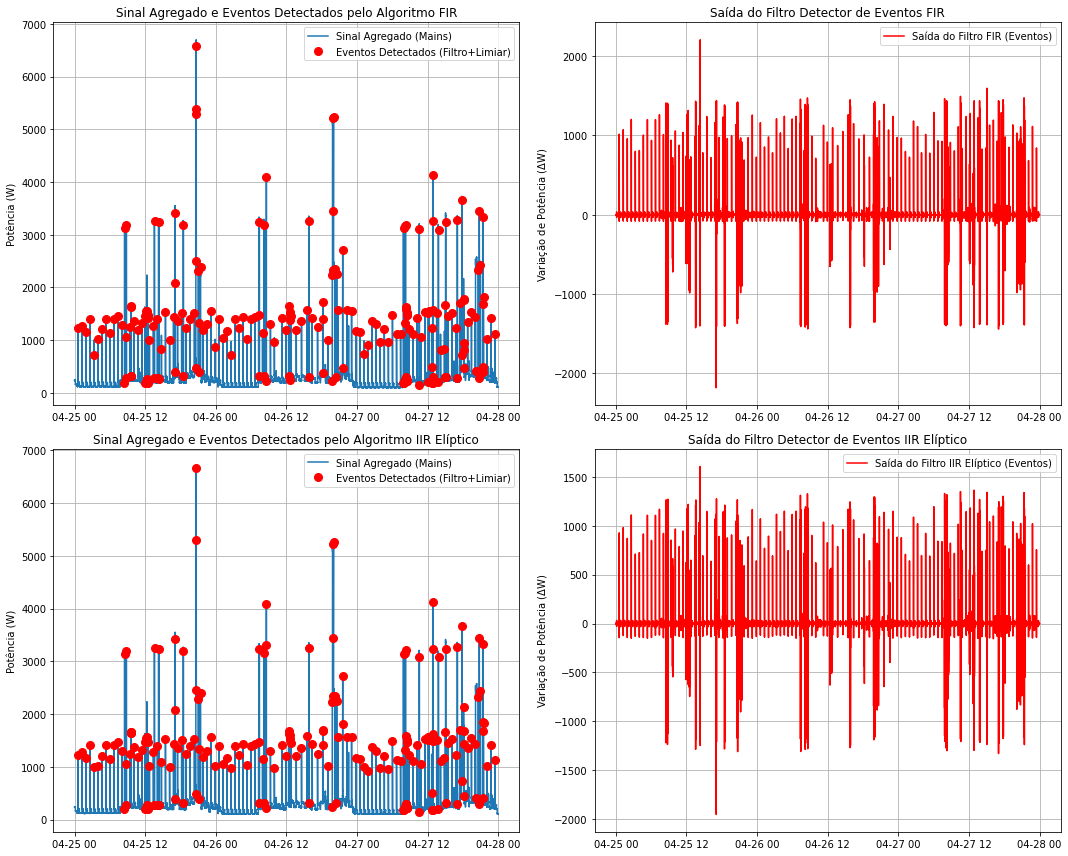

In [138]:
event_signal_ellip = signal.filtfilt(b_ellip, a_ellip, mains_power)
detected_event_timestamps_ellip = apply_and_compare_filters(b_fir, event_signal_ellip, threshold, type="Elíptico")

Agora vamos dar um zoom em períodos específicos dos filtros Butterworth e Elíptico para visualizar as propriedades apresentadas. Nesse caso o Chebyshev ficará de fora por ter uma resposta pouco eficiente para ser analisada, além de ser semelhante ao Elíptico.

Para o Butterworth, o resultado explorado anteriormente no Filtro FIR já deixa claro que ele identifica todos os mesmos pontos, mas aqui uma análise é mais interessante, **o ponto extra que foi identificado**. Oservando a saída do Filtro Butterworth, é possível notar que esse segundo pico de potência, que ultrapassou o limite de 500, foi muito melhor representado na saída do Filtro, contendo uma componente separada de mais de 500 também, o que tornou possível sua identificação.

Além disso, é possível perceber com mais clareza no ponto próximo de 8:15 que no filtro IIR ele ficou um pouco mais deslocado (atrasado) que o equivalente FIR, mas que novamente não foi uma diferença tão significativa para invalidar o filtro.

Total de 4 eventos detectados pelo Filtro FIR com limiar de 500.0W.
Total de 5 eventos detectados pelo filtro IIR Butterworth com limiar de 500.0W.


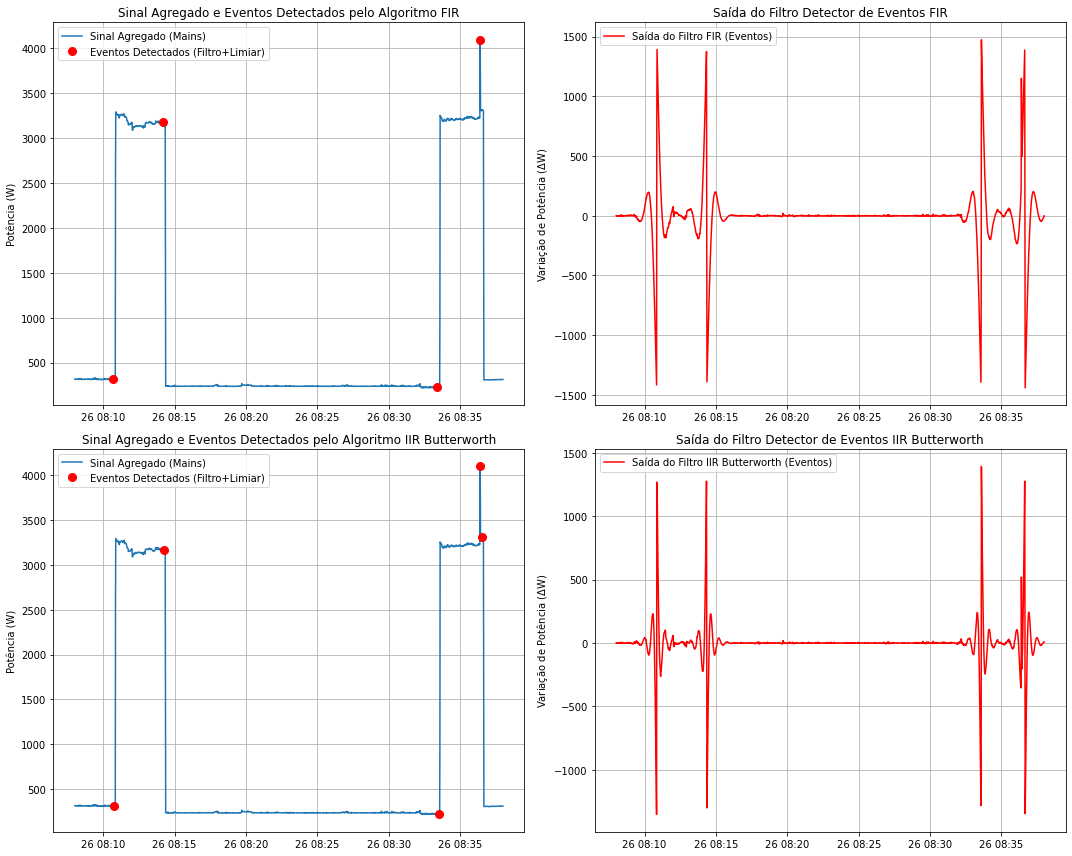

DatetimeIndex(['2013-04-26 08:10:45.599999905+01:00',
               '2013-04-26 08:14:16.400000095+01:00',
               '2013-04-26 08:33:29.700000048+01:00',
               '2013-04-26 08:36:23.599999905+01:00',
               '2013-04-26 08:36:33.599999905+01:00'],
              dtype='datetime64[ns, Europe/London]', freq=None)

In [139]:
dataset.set_window(start="2013-04-26 08:08:00", end="2013-04-26 08:38:00")
elec = dataset.buildings[building_num].elec
mains_power = elec.mains().power_series_all_data().dropna()

event_signal_butter = signal.filtfilt(b_butter, a_butter, mains_power)
apply_and_compare_filters(b_fir, event_signal_butter, threshold, type="Butterworth")

Para o Elíptico é mais interessante analisar **os pontos não identificados**. Oservando a saída do filtro, é possível notar que ele perdeu a identificação de quando o dispositivo ligou ente 20:39 e 20:40, considerando o seu desligamento como ativação, o que fez com que esse ponto fosse perdido. Isso provavelmente ocorreu por conta da defasagem ser menos próxima do modelo FIR para a frequência de corte como o Butterworth.

Além disso, é possível perceber que, por ele não ser maximamente plano, vários *riples* foram gerados, o que também pode ter confudindo a identificação correta nesses cenários que eventos seguidos acontecem mais rapidamente que o filtro consegue amortizar esses lóbulos.

Total de 5 eventos detectados pelo Filtro FIR com limiar de 500.0W.
Total de 4 eventos detectados pelo filtro IIR Elíptico com limiar de 500.0W.


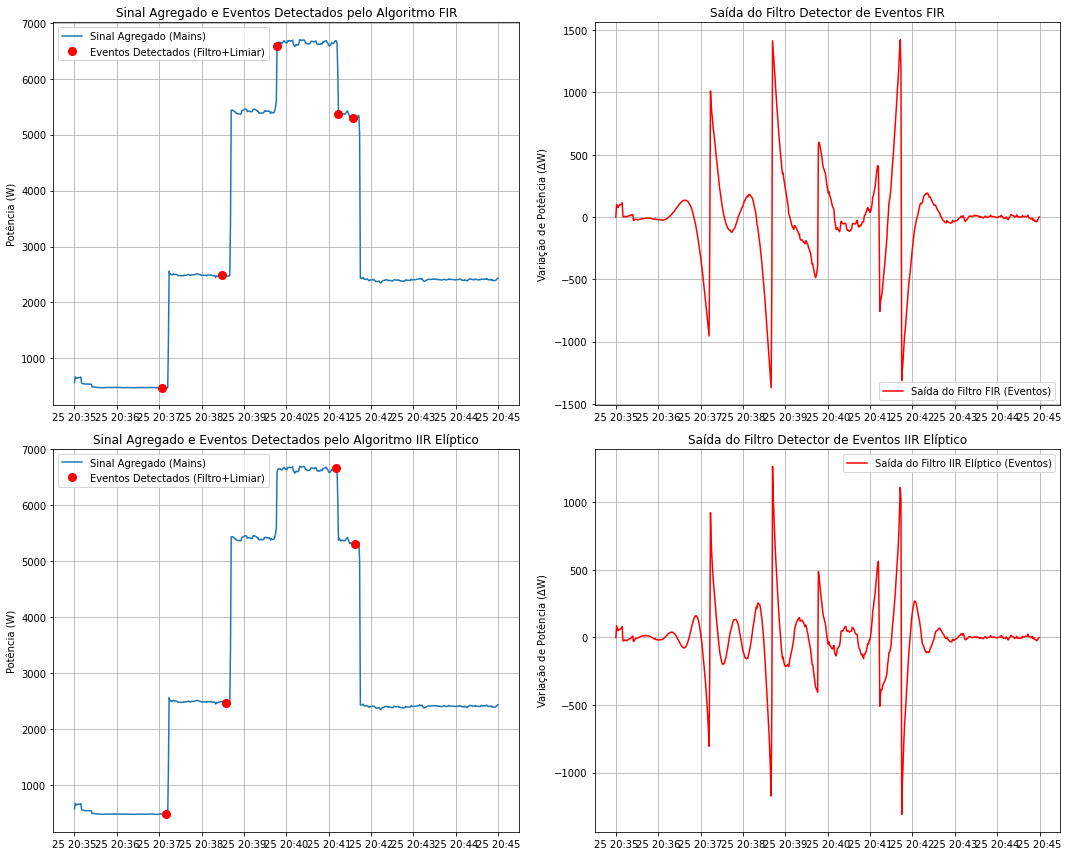

DatetimeIndex(['2013-04-25 20:37:09.900000095+01:00',
               '2013-04-25 20:38:34.900000095+01:00',
               '2013-04-25 20:41:10.700000048+01:00',
               '2013-04-25 20:41:37.799999952+01:00'],
              dtype='datetime64[ns, Europe/London]', freq=None)

In [140]:
dataset.set_window(start="2013-04-25 20:35:00", end="2013-04-25 20:45:00")
elec = dataset.buildings[building_num].elec
mains_power = elec.mains().power_series_all_data().dropna()

event_signal_ellip = signal.filtfilt(b_ellip, a_ellip, mains_power)
apply_and_compare_filters(b_fir, event_signal_ellip, threshold, type="Elíptico")

## 4 - Análise do Filtro Passa Baixa

Por fim, faremos a implementação do filtro passa-baixa da mesmo forma como o passa alta, considerando as mesmas especificações já citadas no trabalho anterior e comparando as estratégias.

### Análise de Magnitude

Novamente, as características já citadas para os outros filtros valem igualmente para o passa-baixa, onde as características do Butterworth fazem ele parecer o mais indicado para a aplicação sem que a ordem dele seja demasiadamente alta para ser utilizado na prática, principalmente levando em consideração que os dados no mundo real serão amostrados em alta frequência.

Ordem necessária para Butterworth: 8
Ordem necessária para Chebyshev I: 5
Ordem necessária para Elíptico: 4
Ordem necessária para FIR: 56


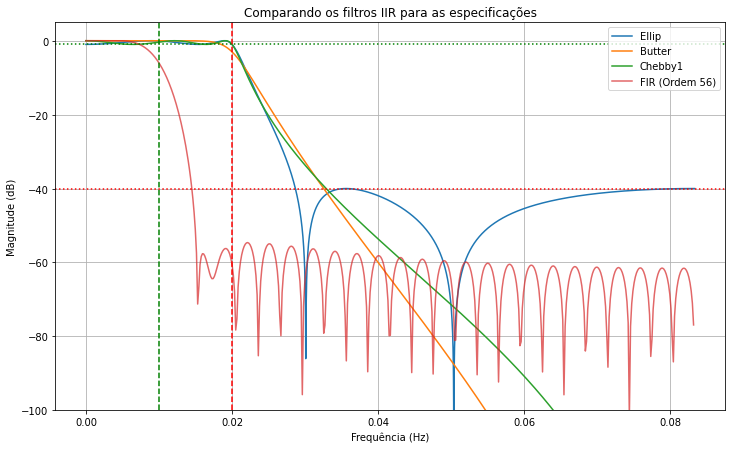

In [141]:
fr = 0.02
fp = 0.01
fs = 1/6.0

# Normalizando
Wp = fp / (fs / 2)
Wr = fr / (fs / 2)

# Calculando a ordem necessária para cada tipo de filtro
ord_b, _ = signal.buttord(Wp, Wr, gpass, gstop)
ord_c, _ = signal.cheb1ord(Wp, Wr, gpass, gstop)
ord_e, _ = signal.ellipord(Wp, Wr, gpass, gstop)
ordem_fir = int(np.ceil(3.3/((fr-fp)/fs)) + 1)

print(f"Ordem necessária para Butterworth: {ord_b}")
print(f"Ordem necessária para Chebyshev I: {ord_c}")
print(f"Ordem necessária para Elíptico: {ord_e}")
print(f"Ordem necessária para FIR: {ordem_fir}")


b_ellip, a_ellip = signal.ellip(ord_e, gpass, gstop, Wr, 'low')
b_butter, a_butter = signal.butter(ord_b, Wr, 'low')
b_chebby, a_chebby = signal.cheby1(ord_c, gpass, Wr, 'low')
b_fir = signal.firwin(ordem_fir, cutoff=fp, fs=fs, window='hamming', pass_zero='lowpass')

# --- Aplicação do Filtro ---
w_fir, h_fir = signal.freqz(b_fir, [1.0], fs=fs)
w_e, h_e = signal.freqz(b_ellip, a_ellip, fs=fs, worN=4096)
w_b, h_b = signal.freqz(b_butter, a_butter, fs=fs, worN=4096)
w_c, h_c = signal.freqz(b_chebby, a_chebby, fs=fs, worN=4096)

plt.figure(figsize=(12, 7))
plt.plot(w_e, 20 * np.log10(abs(h_e)), label='Ellip')
plt.plot(w_b, 20 * np.log10(abs(h_b)), label='Butter')
plt.plot(w_c, 20 * np.log10(abs(h_c)), label='Chebby1')
plt.plot(w_fir, 20 * np.log10(np.abs(h_fir) + 1e-9), label=f'FIR (Ordem {ordem_fir})', alpha=0.7)
plt.title(f'Comparando os filtros IIR para as especificações')
plt.xlabel('Frequência (Hz)'); plt.ylabel('Magnitude (dB)')
plt.axvline(fp, color='g', linestyle='--'); plt.axvline(fr, color='r', linestyle='--')
plt.axhline(-gpass, color='g', linestyle=':'); plt.axhline(-gstop, color='r', linestyle=':')
plt.grid(True, which='both'); plt.ylim(-100, 5)
plt.legend()
plt.show()

### Análise de fase

Aqui já tivemos um resultado melhor do que para o passa-alta, já que todos os filtros apresentaram uma resposta em fase próxima do FIR para a frequência de corte, no entanto os filtros que não são maximamente planos demoraram mais para chegar em uma resposta semelhante, podendo acontecer o mesmo fenômeno de perder amostras.

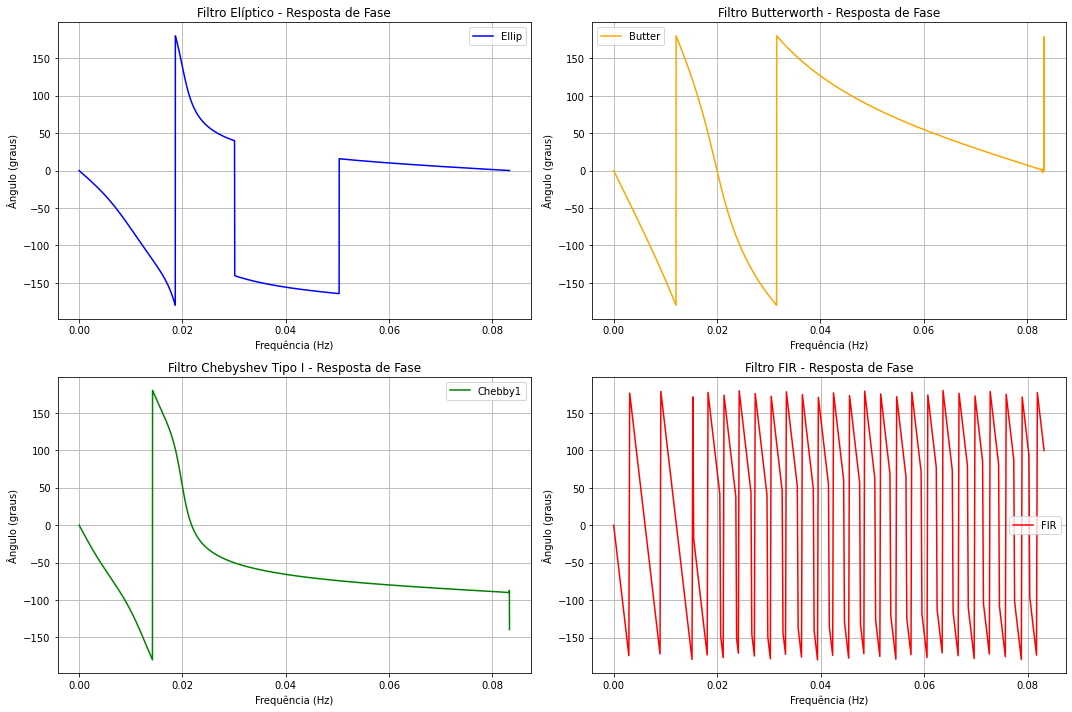

In [142]:
phase_fir =     np.angle(h_fir, deg=True)
phase_butter =  np.angle(h_b, deg=True)
phase_ellip =   np.angle(h_e, deg=True)
phase_cheby =   np.angle(h_c, deg=True)

# Criando uma figura com 4 subplots (2x2)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Gráfico 1: Filtro Elíptico
axes[0, 0].plot(w_e, phase_ellip, label='Ellip', color='blue')
axes[0, 0].set_title('Filtro Elíptico - Resposta de Fase')
axes[0, 0].set_xlabel('Frequência (Hz)')
axes[0, 0].set_ylabel('Ângulo (graus)')
axes[0, 0].grid(True)
axes[0, 0].legend()

# Gráfico 2: Filtro Butterworth
axes[0, 1].plot(w_b, phase_butter, label='Butter', color='orange')
axes[0, 1].set_title('Filtro Butterworth - Resposta de Fase')
axes[0, 1].set_xlabel('Frequência (Hz)')
axes[0, 1].set_ylabel('Ângulo (graus)')
axes[0, 1].grid(True)
axes[0, 1].legend()

# Gráfico 3: Filtro Chebyshev
axes[1, 0].plot(w_c, phase_cheby, label='Chebby1', color='green')
axes[1, 0].set_title('Filtro Chebyshev Tipo I - Resposta de Fase')
axes[1, 0].set_xlabel('Frequência (Hz)')
axes[1, 0].set_ylabel('Ângulo (graus)')
axes[1, 0].grid(True)
axes[1, 0].legend()

# Gráfico 4: Filtro FIR
axes[1, 1].plot(w_fir, phase_fir, label='FIR', color='red')
axes[1, 1].set_title('Filtro FIR - Resposta de Fase')
axes[1, 1].set_xlabel('Frequência (Hz)')
axes[1, 1].set_ylabel('Ângulo (graus)')
axes[1, 1].grid(True)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

### Aplicando Filtro

In [143]:
def compare_fir_iir_low_pass(smoothed_signal, smoothed_signal_iir):
    # --- Aplicação do Filtro ---
    # Criar um Pandas Series para facilitar o acesso por timestamp
    smoothed_series = pd.Series(smoothed_signal, index=mains_power.index)
    smoothed_series_iir = pd.Series(smoothed_signal_iir, index=mains_power.index)

    # --- Plot para Visualização ---
    fig, ax = plt.subplots(1,2,figsize=(15, 6))
    ax[0].plot(mains_power, label='Sinal Original', alpha=0.5)
    ax[0].plot(smoothed_series, label='Sinal Suavizado (Passa-Baixa) FIR', color='green', linewidth=2)
    ax[0].set_title('Sinal Suavizado para Medição de Potência')
    ax[0].set_ylabel('Potência (W)')
    ax[0].grid()
    ax[0].legend()
    
    ax[1].plot(mains_power, label='Sinal Original', alpha=0.5)
    ax[1].plot(smoothed_series_iir, label='Sinal Suavizado (Passa-Baixa) IIR', color='green', linewidth=2)
    ax[1].set_title('Sinal Suavizado para Medição de Potência')
    ax[1].set_ylabel('Potência (W)')
    ax[1].grid()
    ax[1].legend()
    plt.show()

    return smoothed_series_iir

Como podemos perceber abaixo, os filtros acabam por suavizar menos os eventos de impulso devido a suas características de fase e módulo, mas eles não são espressivos o suficiente para atrapalhar no cálculo de obtenção de potência.

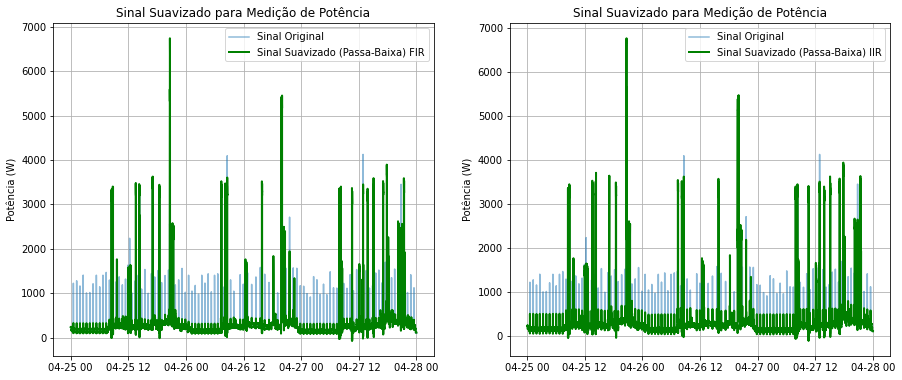

In [144]:
dataset.set_window(start="2013-04-25", end="2013-04-28") # Tempo para casa 2
elec = dataset.buildings[building_num].elec
mains_power = elec.mains().power_series_all_data().dropna()

smoothed_signal = signal.filtfilt(b_fir, 1.0, mains_power)
smoothed_signal_butter = signal.filtfilt(b_butter, a_butter, mains_power)

smoothed_series = pd.Series(smoothed_signal, index=mains_power.index)
smoothed_series_butter = compare_fir_iir_low_pass(smoothed_signal, smoothed_signal_butter)

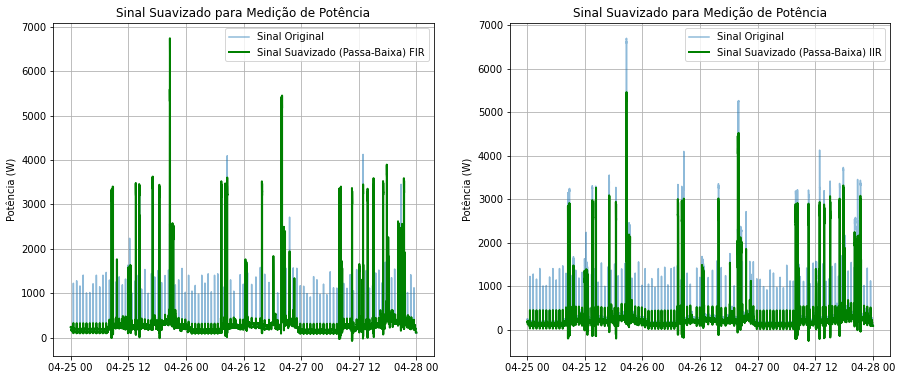

In [145]:
smoothed_signal_ellip = signal.filtfilt(b_ellip, a_ellip, mains_power)
smoothed_series_ellip = compare_fir_iir_low_pass(smoothed_signal, smoothed_signal_ellip)

### Identificação de Dispositivo

Sendo assim, vamos nos aproveitar das funções criados no trabalho anterior para comparar os resultados

In [146]:
def extract_event_features(smoothed_series, detected_event_timestamps):
    event_features = []

    # --- PARÂMETROS DE JANELAMENTO (JUSTIFICADOS) ---
    # Intervalo de guarda para ignorar a transição do filtro. 12 segundos (2 amostras) é um bom começo.
    GUARD_SECONDS = 12
    # Duração da janela para medir a média do estado estável. 30 segundos é um valor robusto.
    WINDOW_SECONDS = 30

    # Cálculo dinâmico em número de amostras
    sampling_period_seconds = (mains_power.index[1] - mains_power.index[0]).total_seconds()
    guard_samples = int(GUARD_SECONDS / sampling_period_seconds)
    window_samples = int(WINDOW_SECONDS / sampling_period_seconds)

    n_samples = len(smoothed_series)
    print(f"Analisando {len(detected_event_timestamps)} eventos candidatos...")
    print(f"Usando {guard_samples} amostras de guarda e {window_samples} amostras de medição.")

    for ts in detected_event_timestamps:
        loc = smoothed_series.index.get_loc(ts)

        # Janela "Antes": termina 'guard_samples' antes do evento
        start_before = loc - guard_samples - window_samples
        end_before = loc - guard_samples

        # Janela "Depois": começa 'guard_samples' depois do evento
        start_after = loc + guard_samples
        end_after = loc + guard_samples + window_samples

        # Verificação de limites para evitar erros
        if start_before < 0 or end_after >= n_samples:
            continue # Pula eventos muito próximos das bordas do sinal

        before_window = smoothed_series.iloc[start_before:end_before]
        after_window = smoothed_series.iloc[start_after:end_after]

        if before_window.isnull().any() or after_window.isnull().any() or before_window.empty or after_window.empty:
            continue

        power_before = before_window.mean()
        power_after = after_window.mean()

        delta_p = power_after - power_before
        event_features.append({'timestamp': ts, 'delta_p': delta_p})
    
    return pd.DataFrame(event_features)

In [147]:
event_feautures_fir = extract_event_features(smoothed_series, detected_event_timestamps_butter)

event_feautures_butter = extract_event_features(smoothed_series_butter, detected_event_timestamps_butter)
event_feautures_ellip = extract_event_features(smoothed_series_ellip, detected_event_timestamps_ellip)

Analisando 212 eventos candidatos...
Usando 12 amostras de guarda e 30 amostras de medição.
Analisando 212 eventos candidatos...
Usando 12 amostras de guarda e 30 amostras de medição.
Analisando 206 eventos candidatos...
Usando 12 amostras de guarda e 30 amostras de medição.


In [148]:
print("--- Iniciando: Identificação com Lógica de 'Melhor Correspondência' ---")

# --- 6.1: Carregar o "Catálogo" de Aparelhos (código inalterado) ---
appliance_catalog = []
for meter in elec.all_meters():
    if not meter.is_site_meter() and meter.appliances:
        for appliance in meter.appliances:
            if 'on_power_threshold' in appliance.metadata and 'max_power' in appliance.metadata:
                appliance_info = {
                    'type': appliance.type['type'],
                    'instance': appliance.metadata.get('instance'),
                    'on_power_threshold': appliance.metadata.get('on_power_threshold'),
                    'max_power': appliance.metadata.get('max_power')
                }
                appliance_catalog.append(appliance_info)

print(f"Catálogo de {len(appliance_catalog)} aparelhos com metadados de potência carregado da Casa {building_num}.")


# --- 6.2: Definição da NOVA Função de Classificação (Mais Inteligente) ---
def classify_by_best_match(delta_p, catalog):
    """Encontra o aparelho com a faixa de potência mais estreita que corresponde ao evento."""
    abs_delta = abs(delta_p)
    possible_matches = []

    # 1. Encontra todos os aparelhos compatíveis
    for appliance in catalog:
        if appliance['on_power_threshold'] <= abs_delta <= appliance['max_power']:
            possible_matches.append(appliance)

    # 2. Decide com base no número de correspondências
    if not possible_matches:
        # Nenhum aparelho compatível encontrado
        return 'unknown'
    elif len(possible_matches) == 1:
        # Apenas uma correspondência, caso fácil
        return possible_matches[0]['type']
    else:
        # 3. Critério de Desempate: escolher a faixa mais estreita
        best_match = None
        smallest_range = float('inf')

        for appliance in possible_matches:
            power_range = appliance['max_power'] - appliance['on_power_threshold']
            if power_range < smallest_range:
                smallest_range = power_range
                best_match = appliance

        return best_match['type']

# --- 6.3: Aplicação da Nova Classificação ---
event_feautures_fir['classified_appliance'] = event_feautures_fir['delta_p'].apply(lambda dp: classify_by_best_match(dp, appliance_catalog))
event_feautures_butter['classified_appliance'] = event_feautures_butter['delta_p'].apply(lambda dp: classify_by_best_match(dp, appliance_catalog))
event_feautures_ellip['classified_appliance'] = event_feautures_ellip['delta_p'].apply(lambda dp: classify_by_best_match(dp, appliance_catalog))

--- Iniciando: Identificação com Lógica de 'Melhor Correspondência' ---
Catálogo de 5 aparelhos com metadados de potência carregado da Casa 2.


In [149]:
def print_results(event_features_df, elec_meters, classification_column='classified_appliance', verbose=True):
    """
    Avalia a classificação de cada evento, imprime os resultados individuais (opcional)
    e calcula as métricas de acurácia finais.

    Parâmetros:
    - event_features_df: DataFrame com os eventos e suas classificações.
    - elec_meters: O objeto MeterGroup da casa para acesso ao ground truth.
    - classification_column: O nome da coluna no DataFrame que contém os rótulos classificados.
    - verbose: Se True, imprime a avaliação de cada evento individualmente.
    """
    # --- 1. Inicialização dos Contadores ---
    total_detected_events = len(event_features_df)
    correct_classifications = 0
    evaluable_events = 0 # Eventos que foram classificados e cujo ground truth foi encontrado

    if verbose:
        print(f"\n--- Avaliação Detalhada (Coluna: '{classification_column}') ---")

    # --- 2. Loop de Avaliação e Contagem ---
    for index, event in event_features_df.iterrows():
        ts = event['timestamp']
        delta_p = event['delta_p']
        classified = event[classification_column]

        if classified != 'unknown':
            try:
                meter_or_group = elec_meters[classified]
                ground_truth_series = meter_or_group.power_series_all_data()

                if ground_truth_series is None or ground_truth_series.empty:
                    if verbose: print(f"Evento em {ts.time()} (ΔP = {delta_p:+.0f}W): Classificado como '{classified}'. Verificação: Ground Truth INDISPONÍVEL.")
                    continue

                position_array = ground_truth_series.index.get_indexer([ts], method='nearest', tolerance=pd.Timedelta('3s'))

                if position_array[0] == -1:
                    if verbose: print(f"Evento em {ts.time()} (ΔP = {delta_p:+.0f}W): Classificado como '{classified}'. Verificação: Nenhum ponto no Ground Truth encontrado na vizinhança.")
                    continue
                
                evaluable_events += 1
                
                nearest_index_pos = position_array[0]
                local_window = ground_truth_series.iloc[max(0, nearest_index_pos - 2) : nearest_index_pos + 3]
                
                if local_window.empty:
                    if verbose: print(f"Evento em {ts.time()} (ΔP = {delta_p:+.0f}W): Classificado como '{classified}'. Verificação: Janela de busca no Ground Truth vazia.")
                    continue
                
                ground_truth_power = local_window.max() if delta_p > 0 else local_window.min()
                is_on_truth = ground_truth_power > 20
                
                is_correct = (delta_p > 0 and is_on_truth) or (delta_p < 0 and not is_on_truth)
                
                if is_correct:
                    correct_classifications += 1
                
                if verbose:
                    evaluation = "CORRETA" if is_correct else "INCORRETA"
                    print(f"Evento em {ts.time()} (ΔP = {delta_p:+.0f}W): Classificado como '{classified}'. Verificação: {evaluation} (Real: {ground_truth_power:.0f}W)")

            except Exception as e:
                if verbose: print(f"Evento em {ts.time()} (ΔP = {delta_p:+.0f}W): Ocorreu um erro inesperado na avaliação: {e}")
    
    # --- 3. Cálculo e Apresentação das Métricas Finais ---
    accuracy_evaluable = (correct_classifications / evaluable_events * 100) if evaluable_events > 0 else 0
    accuracy_overall = (correct_classifications / total_detected_events * 100) if total_detected_events > 0 else 0

    print("\n" + "="*40)
    print("--- Resumo da Eficácia do Algoritmo ---")
    print(f"Coluna Avaliada: '{classification_column}'")
    print("-" * 40)
    print(f"Total de Eventos Detectados: {total_detected_events}")
    print(f"Eventos Classificados e Verificáveis: {evaluable_events}")
    print(f"Classificações Corretas: {correct_classifications}")
    print("-" * 40)
    print(f"Acurácia (sobre eventos verificáveis): {accuracy_evaluable:.2f}%")
    print(f"Acurácia Geral (sobre todos os eventos): {accuracy_overall:.2f}%")
    print("="*40)

### Comparando resultados

Agora, podemos comparar os resultados obtidos nos dois filtros IIR com o filtro FIR

In [150]:
print("--- Resultados da Avaliação para o Filtro FIR ---")
print_results(event_feautures_fir, elec, verbose=False)

--- Resultados da Avaliação para o Filtro FIR ---

--- Resumo da Eficácia do Algoritmo ---
Coluna Avaliada: 'classified_appliance'
----------------------------------------
Total de Eventos Detectados: 212
Eventos Classificados e Verificáveis: 51
Classificações Corretas: 26
----------------------------------------
Acurácia (sobre eventos verificáveis): 50.98%
Acurácia Geral (sobre todos os eventos): 12.26%

--- Resumo da Eficácia do Algoritmo ---
Coluna Avaliada: 'classified_appliance'
----------------------------------------
Total de Eventos Detectados: 212
Eventos Classificados e Verificáveis: 51
Classificações Corretas: 26
----------------------------------------
Acurácia (sobre eventos verificáveis): 50.98%
Acurácia Geral (sobre todos os eventos): 12.26%


Aqui vemos um fenômeno interessante, o filtro Butterworth conseguiu obter uma amostra a mais no passo anterior e ela foi corretamente identificada, de forma que não só valida que nosso filtro está correto, como não identificou nenhum falso positivo, visto que sua precisão foi maior que o FIR. 

In [151]:
print("\n--- Avaliação Preliminar da Classificação com Regras Estendidas ---")
print_results(event_feautures_butter, elec, verbose=False)


--- Avaliação Preliminar da Classificação com Regras Estendidas ---

--- Resumo da Eficácia do Algoritmo ---
Coluna Avaliada: 'classified_appliance'
----------------------------------------
Total de Eventos Detectados: 212
Eventos Classificados e Verificáveis: 50
Classificações Corretas: 26
----------------------------------------
Acurácia (sobre eventos verificáveis): 52.00%
Acurácia Geral (sobre todos os eventos): 12.26%

--- Resumo da Eficácia do Algoritmo ---
Coluna Avaliada: 'classified_appliance'
----------------------------------------
Total de Eventos Detectados: 212
Eventos Classificados e Verificáveis: 50
Classificações Corretas: 26
----------------------------------------
Acurácia (sobre eventos verificáveis): 52.00%
Acurácia Geral (sobre todos os eventos): 12.26%


In [152]:
print("\n--- Tabela Final de Eventos Classificados ---")
print(event_feautures_butter)


--- Tabela Final de Eventos Classificados ---
                              timestamp      delta_p classified_appliance
0   2013-04-25 00:34:17.400000095+01:00    88.689962               fridge
1   2013-04-25 01:15:32.099999905+01:00    88.755202               fridge
2      2013-04-25 01:56:35.500000+01:00    89.436039               fridge
3             2013-04-25 02:37:21+01:00    88.932779               fridge
4   2013-04-25 03:18:10.599999905+01:00    88.533800               fridge
..                                  ...          ...                  ...
207 2013-04-27 21:29:33.200000048+01:00  1345.833947      washing machine
208 2013-04-27 21:30:28.200000048+01:00 -1465.283484      washing machine
209           2013-04-27 22:07:56+01:00    86.441586               fridge
210 2013-04-27 22:48:07.299999952+01:00    98.474548               fridge
211           2013-04-27 23:28:50+01:00    88.474598               fridge

[212 rows x 3 columns]


Agora no filtro Elíptico outro fenômeno aconteceu. Como ele obteve menos amostras, mas as que ele obteve estão condizentes da mesma forma que o Filtro FIR, ele acabou por ter uma precisão maior, mas não por achar mais amostrar corretas, e sim por ter menos amostras, o que mais uma vez contribui a favor da escolha do filtro Butterworth

In [153]:
print("\n--- Avaliação Preliminar da Classificação com Regras Estendidas ---")
print_results(event_feautures_ellip, elec, verbose=False)


--- Avaliação Preliminar da Classificação com Regras Estendidas ---

--- Resumo da Eficácia do Algoritmo ---
Coluna Avaliada: 'classified_appliance'
----------------------------------------
Total de Eventos Detectados: 206
Eventos Classificados e Verificáveis: 45
Classificações Corretas: 25
----------------------------------------
Acurácia (sobre eventos verificáveis): 55.56%
Acurácia Geral (sobre todos os eventos): 12.14%

--- Resumo da Eficácia do Algoritmo ---
Coluna Avaliada: 'classified_appliance'
----------------------------------------
Total de Eventos Detectados: 206
Eventos Classificados e Verificáveis: 45
Classificações Corretas: 25
----------------------------------------
Acurácia (sobre eventos verificáveis): 55.56%
Acurácia Geral (sobre todos os eventos): 12.14%


In [154]:
print("\n--- Tabela Final de Eventos Classificados ---")
print(event_feautures_ellip)


--- Tabela Final de Eventos Classificados ---
                              timestamp      delta_p classified_appliance
0   2013-04-25 00:34:17.400000095+01:00    68.848939               fridge
1   2013-04-25 01:15:32.099999905+01:00    69.563366               fridge
2      2013-04-25 01:56:35.500000+01:00    69.374141               fridge
3             2013-04-25 02:37:21+01:00    69.214799               fridge
4   2013-04-25 03:18:10.599999905+01:00    69.750470               fridge
..                                  ...          ...                  ...
201 2013-04-27 21:29:33.200000048+01:00  1064.547458      washing machine
202 2013-04-27 21:30:29.200000048+01:00 -1163.969418      washing machine
203           2013-04-27 22:07:56+01:00    66.762436               fridge
204 2013-04-27 22:48:07.299999952+01:00    76.792756               fridge
205           2013-04-27 23:28:50+01:00    68.575144               fridge

[206 rows x 3 columns]


E com isso, concluímos a análise e implementação de identificação de cargas utilzando Filtros FIR e IIR sobre um dataset NILM